In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

import xgboost as xgb

In [2]:
# Seed value for random functions
SEED = 1

## Dataset

- This dataset contains various features describing students such as gender, age, socioeconomic status, study hours per week, etc. as well as their score on a standardized test (`JAMB_score`).
- The goal of this homework is to create a regression model for predicting student performance (`JAMB score`).

In [3]:
# Download the data
data = 'https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv'
if not os.path.exists('../data/jamb_exam_results.csv'):
    !wget $data -P ../data

--2024-11-04 22:28:10--  https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv [following]
--2024-11-04 22:28:10--  https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 391501 (382K) [text/plain]
Saving to: ‘../data/jamb_exam_results.csv’

jamb_exam_results.c 100%[===================>] 382.33K  --.-KB/s    in 0.09s   

2024-11-04 22:28:10 (4.38 MB/s) - ‘../data/

## Dataset Preparation

First, let's make the names lowercase:

```df.columns = df.columns.str.lower().str.replace(' ', '_')```

Preparation:

- Remove the `student_id` column.
- Fill missing values with zeros.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state` parameter to 1.
- Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [4]:
# Read in data to a DataFrame
df = pd.read_csv('../data/jamb_exam_results.csv')
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [5]:
# Make column names lowercase
df.columns = df.columns.str.lower()
# Remove the `student_id` column
del df['student_id']

In [6]:
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,22,Female,Medium,Tertiary,1


In [7]:
# Check which features have missing values
df.isnull().sum()

jamb_score                        0
study_hours_per_week              0
attendance_rate                   0
teacher_quality                   0
distance_to_school                0
school_type                       0
school_location                   0
extra_tutorials                   0
access_to_learning_materials      0
parent_involvement                0
it_knowledge                      0
age                               0
gender                            0
socioeconomic_status              0
parent_education_level          891
assignments_completed             0
dtype: int64

In [8]:
# Fill missing values with zeros
df = df.fillna(0)

In [9]:
# Split data into train, validation, and test sets (60/20/20 split)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=(0.2/0.8), random_state=SEED)

# Extract target vectors
y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

# Delete target variable from DataFrame
del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

# Prepare dictionaries for DictVectorizer
dicts_train = df_train.to_dict(orient='records')
dicts_val = df_val.to_dict(orient='records')
dicts_test = df_test.to_dict(orient='records')

# Instantiate DictVectorizer object
dv = DictVectorizer(sparse=True)

# Get feature matrices from DictVectorizer
X_train = dv.fit_transform(dicts_train)
X_val = dv.transform(dicts_val)
X_test = dv.transform(dicts_test)

## Question 1

Let's train a decision tree regressor to predict the `jamb_score` variable.

Train a model with `max_depth=1`.
Which feature is used for splitting the data?

- study_hours_per_week
- attendance_rate
- teacher_quality
- distance_to_school

In [10]:
# Train a DecisionTreeRegressor model
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [11]:
# Get feature names
feature_names = list(dv.get_feature_names_out())
# Print tree structure
print(export_text(dtr, feature_names=feature_names))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



__Answer__: The `study_hours_per_week` feature is used for splitting the data.

## Question 2

Train a random forest regressor with these parameters:

- `n_estimators=10`
- `random_state=1`
- `n_jobs=-1`(optional - to make training faster)

What's the RMSE of this model on the validation data?

- 22.13
- 42.13
- 62.13
- 82.12

In [12]:
# Train a RandomForestRegressor model
rfr = RandomForestRegressor(n_estimators=10, random_state=SEED, n_jobs=-1)
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [13]:
# Evaluate model on validation data
y_pred = rfr.predict(X_val)
root_mean_squared_error(y_val, y_pred).round(2)

42.14

__Answer__: The RMSE of this model on the validation data is 42.14.

## Question 3

Now let's experiment with the `n_estimators` parameter

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to `1`.
- Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the answer.

- 10
- 25
- 80
- 200

In [14]:
# Store RMSE scores
scores = []

# Train RF models with varying n_estimators and evaluate on validation set
for n in range(10, 201, 10):
    rfr = RandomForestRegressor(n_estimators=n, random_state=SEED, n_jobs=-1)
    rfr.fit(X_train, y_train)

    y_pred = rfr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    scores.append([n, rmse])

In [15]:
# Convert scores to a DataFrame
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
df_scores.head()

,n_estimators,rmse
0,10,42.137242
1,20,41.461215
2,30,41.106171
3,40,40.917194
4,50,40.852279


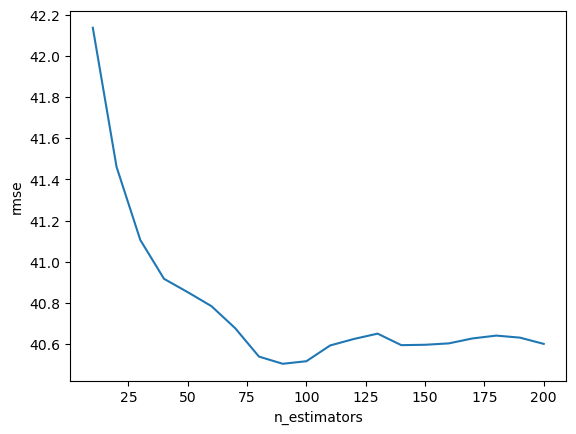

In [16]:
# Plot the scores
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.xlabel('n_estimators')
plt.ylabel('rmse')
plt.show()

In [17]:
# Round RMSE to 3 decimal places and find row with min RMSE
df_scores.rmse = df_scores.rmse.round(3)
df_scores.iloc[df_scores.rmse.idxmin()]

n_estimators    90.000
rmse            40.504
Name: 8, dtype: float64

In [18]:
df_scores.iloc[5:11]

,n_estimators,rmse
5,60,40.784
6,70,40.677
7,80,40.539
8,90,40.504
9,100,40.517
10,110,40.593


__Answer__: Although RMSE stops improving at `n_estimators=90`, a close second value is `n_estimators=80`.

## Question 4

Let's select the best `max_depth`:

- Try different values of `max_depth`: `[10, 15, 20, 25]`
- For each of these values,
    - try different values of `n_estimators` from 10 till 200 (with step 10)
    - calculate the mean RMSE
- Fix the random seed: `random_state=1`

What's the best `max_depth`, using the mean RMSE?

- 10
- 15
- 20
- 25

In [19]:
# Store score DataFrame for each value of max_depth
score_dfs = {}
# Depth values to try
depths = [10, 15, 20, 25]

# Train RF models with varying depths and n_estimators and evaluate on validation set
for d in depths:
    rmse_scores = []
    for n in range(10, 201, 10):
        rfr = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=SEED,
                                    n_jobs=-1)
        rfr.fit(X_train, y_train)
    
        y_pred = rfr.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        rmse_scores.append([n, rmse])
    score_dfs['max_depth=%d' % d] = pd.DataFrame(rmse_scores, columns=['n_estimators', 'rmse'])

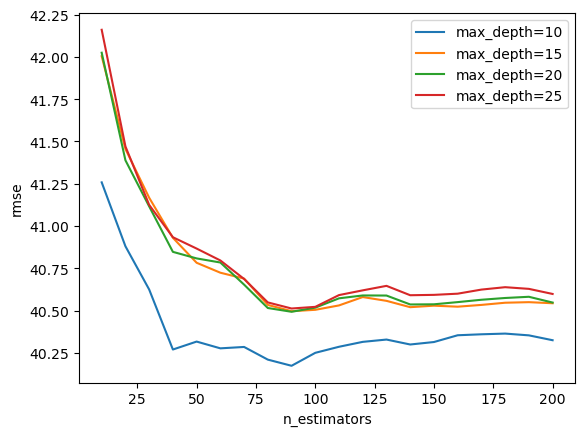

In [20]:
# Plot the scores for each choice of max_depth
for d in depths:
    key = 'max_depth=%d' % d
    score_df = score_dfs[key]
    
    plt.plot(score_df.n_estimators, score_df.rmse, label=key)

plt.xlabel('n_estimators')
plt.ylabel('rmse')
plt.legend()
plt.show()

In [21]:
# Compute mean RMSE for each value of max_depth
mean_rmses = []
for d in depths:
    key = 'max_depth=%d' % d
    mean_rmse = score_dfs[key]['rmse'].mean().round(3)
    mean_rmses.append([d, mean_rmse])

mean_rmses

[[10, 40.392], [15, 40.735], [20, 40.74], [25, 40.788]]

In [22]:
# Find the max_depth value with lowest mean RMSE
best_depth = sorted(mean_rmses, key=lambda x: x[1])[0][0]
best_depth

10

__Answer__: The best `max_depth` value (lowest mean RMSE) is 10.

## Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

- Train the model with these parameters:
    - `n_estimators=10`,
    - `max_depth=20`,
    - `random_state=1`,
    - `n_jobs=-1` (optional)
- Get the feature importance information from this model

What's the most important feature (among these 4)?

- `study_hours_per_week`
- `attendance_rate`
- `distance_to_school`
- `teacher_quality`

In [23]:
# Train the RandomForestRegressor model
rfr = RandomForestRegressor(n_estimators=10,
                            max_depth=10,
                            random_state=SEED,
                            n_jobs=-1)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=10, n_jobs=-1, random_state=1)

In [24]:
# Get features sorted in descending order by feature importance
importance_ordered_features = sorted(
    list(zip(list(dv.get_feature_names_out()), rfr.feature_importances_)),
    key=lambda x : x[1],
    reverse=True
)

importance_ordered_features

[('study_hours_per_week', 0.28497328160551144),
 ('attendance_rate', 0.15429736778675385),
 ('distance_to_school', 0.12298216097315495),
 ('teacher_quality', 0.09849798442726306),
 ('age', 0.06056468399086597),
 ('socioeconomic_status=High', 0.031709028931240286),
 ('assignments_completed', 0.02747827707688874),
 ('parent_involvement=High', 0.024710510720920998),
 ('it_knowledge=High', 0.018602584871164923),
 ('parent_education_level=Secondary', 0.013924096773195688),
 ('parent_education_level=Primary', 0.012890892210876451),
 ('parent_education_level=Tertiary', 0.01250159516695426),
 ('parent_involvement=Low', 0.012346673486464425),
 ('parent_involvement=Medium', 0.01043769630139783),
 ('extra_tutorials=Yes', 0.010175257192416505),
 ('access_to_learning_materials=No', 0.009603224953395849),
 ('socioeconomic_status=Low', 0.00954657395658525),
 ('it_knowledge=Low', 0.009353729488259077),
 ('access_to_learning_materials=Yes', 0.008765612352292338),
 ('gender=Male', 0.008465249075202052),

In [25]:
# Find most important feature among the four options
candidate_features = ['study_hours_per_week', 'attendance_rate',
                      'distance_to_school', 'teacher_quality']
[(feat, imp) for (feat, imp) in importance_ordered_features if feat in candidate_features][0][0]

'study_hours_per_week'

__Answer__: The most important feature (among the 4 options) is `study_hours_per_week`.

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

- 0.3
- 0.1
- Both give equal value

In [26]:
# Get feature names from DictVectorizer
feature_names = list(dv.get_feature_names_out())

# Create train and validation DMatrices for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)

# Create a watchlist for monitoring train and validation performance
watchlist = [(dtrain, 'train'), (dval, 'val')]

# Dictionary to store RMSE DataFrames for different eta values
score_dfs = {}

In [27]:
# Method to parse XGBoost output: lines like '[0]\ttrain-rmse:42.69384\tval-rmse:44.89114'
def parse_xgboost_output(output):
    scores = []
    for line in output.split('\n'):
        if line == '':
            continue
        
        split = line.split('\t')
        
        n_iter = int(split[0].strip('[]'))
        train_rmse = float(split[1].split(':')[1])
        val_rmse = float(split[2].split(':')[1])

        scores.append([n_iter, train_rmse, val_rmse])
    return pd.DataFrame(scores, columns=['n_iter', 'train_rmse', 'val_rmse'])

In [28]:
# XGBoost parameters (eta=0.3)
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [29]:
%%capture output

# Train the XGBoost model
model = xgb.train(xgb_params,
                  dtrain,
                  evals=watchlist,
                  num_boost_round=100)

In [30]:
# Parse the XGBoost monitoring output and store DataFrame for analysis
xgb_out = output.stdout

key='eta=%.1f' % xgb_params['eta']
score_dfs[key] = parse_xgboost_output(xgb_out)

In [31]:
# XGBoost parameters (eta=0.1)
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [32]:
%%capture output

# Train the XGBoost model
model = xgb.train(xgb_params,
                  dtrain,
                  evals=watchlist,
                  num_boost_round=100)

In [33]:
# Parse the XGBoost monitoring output and store DataFrame for analysis
xgb_out = output.stdout

key='eta=%.1f' % xgb_params['eta']
score_dfs[key] = parse_xgboost_output(xgb_out)

In [34]:
score_dfs.keys()

dict_keys(['eta=0.3', 'eta=0.1'])

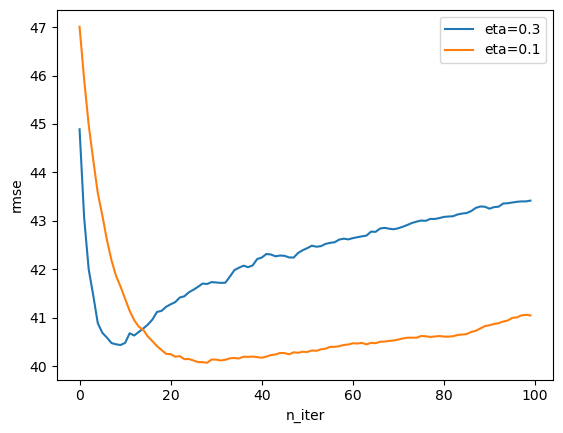

In [35]:
# Plot the scores for each choice of eta
for key, score_df in score_dfs.items():
    plt.plot(score_df.n_iter, score_df.val_rmse, label=key)

plt.xlabel('n_iter')
plt.ylabel('rmse')
plt.legend()

__Answer__: The smaller value of `eta` (`eta=0.1`) leads to the best RMSE score on the validation dataset. A smaller step size implies slower, but more stable optimization.